# This demonstrates how to do a spatial simulation with a susceptible, resistant, and producer strains, all using toy metabolic models, in COMETS.

In [1]:
import cobra
import random
from cobra import Metabolite, Reaction, Model
import pandas as pd
import os

In [2]:
import cometspy as c

# Build the toy models. I'm putting the function I use here for visibility, although usually I keep it in a separate file which I import.

In [50]:
def make_RPS_cobra_models_biomass_cost(growth_rate = 1., toxin_cost = 0.02, resistance_cost = 0.0, toxin_prod = 1.):
    # this is different from make RPS cobra models because the toxin and resistance cost is put into the
    # biomass reaction, rather than a separate reaction. this is important because toxins will only
    # be created during growth.also, no need to multiply costs by growth rate. in all cases, they
    # vary directly with growth rate. finally, in all cases as much toxin is produced as carbon is taken
    # up, regardless of growth rate.
    #
    # These toy models use "carbon_c" to grow--that is the only resource
    #
    # the toxin is called "toxin_e"
    '''
    @toxin_prod:  a multiplier.  the multiple of mmol of toxin made per gram of carbon taken up
    '''
    carbon_e = Metabolite(id = "carbon_e",
               compartment = "e")
    carbon_c = Metabolite(id = "carbon_c",
                   compartment = "c")
    EX_carbon_e = Reaction(id = "EX_carbon_e",
                      lower_bound = -growth_rate, # growth rate
                      upper_bound = 1000.)
    EX_carbon_e.add_metabolites({carbon_e: -1})
    carbon_transfer = Reaction(id = "carbon_transfer",
                          lower_bound = 0.,
                          upper_bound = 1000.)
    carbon_transfer.add_metabolites({carbon_e: -1,
                                carbon_c: 1})
    Biomass = Reaction(id = "Biomass",
                  lower_bound = 0.,
                  upper_bound = 1000.)
    Biomass.add_metabolites({carbon_c: -1.})
    # make the toxicity-related metabolites and reactions
    toxin_c = Metabolite(id = "toxin_c", compartment = "c")
    toxin_e = Metabolite(id = "toxin_e", compartment = "e")

    EX_toxin_e = Reaction(id = "EX_toxin_e",
                         lower_bound = -1000.,
                         upper_bound = 1000.)
    EX_toxin_e.add_metabolites({toxin_e: -1})

    toxin_transfer = Reaction(id = "toxin_transfer",
                             lower_bound = -1000.,
                             upper_bound = 0.)
    toxin_transfer.add_metabolites({toxin_e: -1,
                                   toxin_c: 1})

    Biomass_producer = Reaction(id = "Biomass",
                  lower_bound = 0.,
                  upper_bound = 1000.)
    Biomass_producer.add_metabolites({carbon_c: -(1. + toxin_cost + resistance_cost),
                                     toxin_c: toxin_prod * (1. + toxin_cost + resistance_cost)})

    Biomass_resistant = Reaction(id = "Biomass",
                  lower_bound = 0.,
                  upper_bound = 1000.)
    Biomass_resistant.add_metabolites({carbon_c: -(1. + resistance_cost)})

    producer = Model("producer")
    producer.add_reactions([EX_carbon_e, carbon_transfer, Biomass_producer,
                        EX_toxin_e, toxin_transfer])
    producer.objective = Biomass_producer

    resistant = Model("resistant")
    resistant.add_reactions([EX_carbon_e, carbon_transfer, Biomass_resistant])
    resistant.objective = Biomass_resistant

    susceptible = Model("susceptible")
    susceptible.add_reactions([EX_carbon_e, carbon_transfer, Biomass,
                        EX_toxin_e])
    susceptible.objective = Biomass
    return((producer, resistant, susceptible))

In [51]:
growth_rate = 0.75

producer, resistant, susceptible = make_RPS_cobra_models_biomass_cost(growth_rate = growth_rate, toxin_cost = 0., toxin_prod = 15)

# Now make the COMETS models from these, and add a signal to the susceptible which linearly reduces growth rate until the toxin concentration = 1M, when the growth ceases altogether.

In [52]:
P = c.model(producer)
R = c.model(resistant)
S = c.model(susceptible)

P.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
R.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
S.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

In [53]:
producer.rmetabo

'carbon_c --> 15.0 toxin_c'

In [54]:
producer.slim_optimize()

0.75

# Note that comets erroneously assumes the biomass equation is an exchange in the susceptible and resistant, because it is unbalanced. So we fix that first

In [21]:
R.reactions.loc[R.reactions.REACTION_NAMES == "Biomass", "EXCH"] = False
index = R.reactions.loc[R.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"].values[0]
R.reactions.loc[R.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"] = 0
R.reactions.loc[R.reactions.EXCH_IND > index, "EXCH_IND"] -= 1

S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "EXCH"] = False
index = S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"].values[0]
S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "EXCH_IND"] = 0
S.reactions.loc[S.reactions.EXCH_IND > index, "EXCH_IND"] -= 1

# Now we add the "signal" to susceptible, which reduces growth rate proportionate to [toxin_e]. We use a "bounded_linear" function for this, because we don't want the upper bound of growth rate to go negative. 

In [22]:
biomass_id = S.reactions.loc[S.reactions.REACTION_NAMES == "Biomass", "ID"].values[0]
toxin_exch_id = S.reactions.loc[S.reactions.REACTION_NAMES == "EX_toxin_e", "EXCH_IND"].values[0]

In [23]:
gr_absense_of_toxin = growth_rate
toxin_conc_where_effect_starts = 0.
slope_of_toxin_effect = -growth_rate
toxin_conc_where_effect_saturates = 15
S.add_signal(biomass_id, toxin_exch_id, 'ub', 'bounded_linear', 
             parms = [gr_absense_of_toxin, 
                      toxin_conc_where_effect_starts, 
                      slope_of_toxin_effect,
                     toxin_conc_where_effect_saturates])
S.signals

/opt/miniconda3/lib/python3.8/site-packages/cometspy/model.py:232: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.signals = self.signals.append(new_row, ignore_index=True)


,REACTION_NUMBER,EXCH_IND,BOUND,FUNCTION,PARAMETERS,REACTION_NAMES,EXCH
0,3,2,ub,bounded_linear,"[0.75, 0.0, -0.75, 15]",Biomass,toxin_e


# First lets do a well-mixed simulation.

In [24]:
S.initial_pop = [0, 0, 1.e-10]
R.initial_pop = [0, 0, 1.e-10]
P.initial_pop = [0, 0, 1.e-10]

l = c.layout([P, R, S])
l.set_specific_metabolite("carbon_e", 4.e-7)

p = c.params()
p.set_param("defaultVmax", 1.)
p.set_param("defaultKm", 0.000001) 
p.set_param('maxCycles', 300)
p.set_param('timeStep', 0.1)
p.set_param('spaceWidth', 0.02) # i.e. 2cm x 2cm
p.set_param('writeMediaLog', True)
p.set_param('MediaLogRate', 1)
p.set_param('writeFluxLog', True)
p.set_param('FluxLogRate', 1)
p.set_param("totalBiomassLogRate", 1)

In [25]:
sim = c.comets(l, p)

In [26]:
sim.run()


Running COMETS simulation ...

Debug Here ...
Done!


In [27]:
sim.total_biomass

,cycle,producer,resistant,susceptible
0,0,1.000000e-10,1.000000e-10,1.000000e-10
1,1,1.073529e-10,1.075000e-10,1.075000e-10
2,2,1.152465e-10,1.155625e-10,1.155625e-10
3,3,1.237206e-10,1.242297e-10,1.242297e-10
4,4,1.328176e-10,1.335469e-10,1.335469e-10
...,...,...,...,...
296,296,1.208292e-07,1.385281e-07,1.385281e-07
297,297,1.208292e-07,1.385281e-07,1.385281e-07
298,298,1.208292e-07,1.385281e-07,1.385281e-07
299,299,1.208292e-07,1.385281e-07,1.385281e-07


In [28]:
fifteen = sim.total_biomass

In [18]:
one = sim.total_biomass

In [29]:
one

,cycle,producer,resistant,susceptible
0,0,1.000000e-10,1.000000e-10,1.000000e-10
1,1,1.073529e-10,1.075000e-10,1.075000e-10
2,2,1.152465e-10,1.155625e-10,1.155625e-10
3,3,1.237206e-10,1.242297e-10,1.242297e-10
4,4,1.328176e-10,1.335469e-10,1.335469e-10
...,...,...,...,...
296,296,1.208292e-07,1.385281e-07,1.385281e-07
297,297,1.208292e-07,1.385281e-07,1.385281e-07
298,298,1.208292e-07,1.385281e-07,1.385281e-07
299,299,1.208292e-07,1.385281e-07,1.385281e-07


# Notice that susceptible ends up lower than resistant, but higher than producer. This all makes sense: producer has a cost of making the toxin (2% growth rate), resistant has no cost, and susceptible slowly decreases in growth rate.

In [21]:
sim.total_biomass.plot(x = "cycle")

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [26]:
sim.total_biomass

,cycle,producer,resistant,susceptible
0,0,1.000000e-10,1.000000e-10,1.000000e-10
1,1,1.073529e-10,1.075000e-10,1.075000e-10
2,2,1.152465e-10,1.155625e-10,1.155625e-10
3,3,1.237206e-10,1.242297e-10,1.242297e-10
4,4,1.328176e-10,1.335469e-10,1.335469e-10
...,...,...,...,...
296,296,1.208292e-07,1.385281e-07,1.385281e-07
297,297,1.208292e-07,1.385281e-07,1.385281e-07
298,298,1.208292e-07,1.385281e-07,1.385281e-07
299,299,1.208292e-07,1.385281e-07,1.385281e-07


(0.7, 0.8)

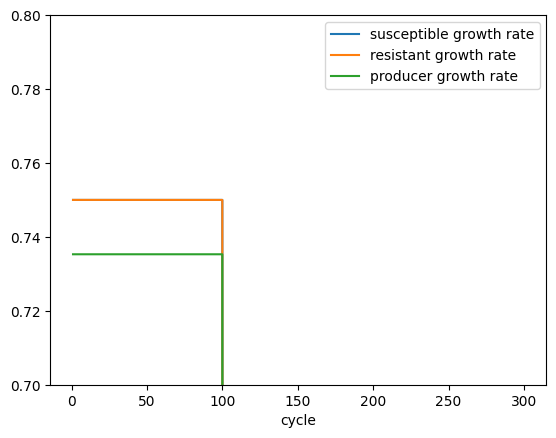

In [15]:
ax = sim.fluxes_by_species["susceptible"].plot(x = "cycle", y = "Biomass", label = "susceptible growth rate")
sim.fluxes_by_species["resistant"].plot(x = "cycle", y = "Biomass", 
                                        ax = ax, label = "resistant growth rate")
sim.fluxes_by_species["producer"].plot(x = "cycle", y = "Biomass", 
                                        ax = ax, label = "producer growth rate")
ax.set_ylim(0.7,0.8)

# the things which will affect "who wins" in these sims are the toxin cost, the toxin production rate (by default it is 1mmol toxin / gram growth), the total amount of carbon, the initial pop, and the spacewidth. Spacewidth is true even in well-mixed because it influences the concentration of the toxin (mmol / spaceWidth^3)--it is in fact a critical value.

In [47]:
S.initial_pop = [0, 0, 1.e-10]
R.initial_pop = [0, 0, 1.e-10]
P.initial_pop = [0, 0, 1.e-10]

l = c.layout([P, R, S])
l.set_specific_metabolite("carbon_e", 4.e-7)

p = c.params()
p.set_param("defaultVmax", 1.)
p.set_param("defaultKm", 0.000001) 
p.set_param('maxCycles', 300)
p.set_param('timeStep', 0.1)
p.set_param('spaceWidth', 0.008) # smaller!
p.set_param('writeMediaLog', True)
p.set_param('MediaLogRate', 1)
p.set_param('writeFluxLog', True)
p.set_param('FluxLogRate', 1)
p.set_param("totalBiomassLogRate", 1)

sim = c.comets(l, p)
#sim.VERSION = 'comets_multitoxin.jar'
#sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()


Running COMETS simulation ...

Debug Here ...
Done!


In [48]:
sim.total_biomass

,cycle,producer,resistant,susceptible
0,0,1.000000e-10,1.000000e-10,1.000000e-10
1,1,1.073529e-10,1.075000e-10,1.075000e-10
2,2,1.152465e-10,1.155625e-10,1.155625e-10
3,3,1.237206e-10,1.242297e-10,1.242297e-10
4,4,1.328176e-10,1.335469e-10,1.335469e-10
...,...,...,...,...
296,296,1.208292e-07,1.385281e-07,1.385281e-07
297,297,1.208292e-07,1.385281e-07,1.385281e-07
298,298,1.208292e-07,1.385281e-07,1.385281e-07
299,299,1.208292e-07,1.385281e-07,1.385281e-07


# Now do it in a spatial world. Basically the same as we've done before. I'm doing a quick random locs func that is a bit simpler from that in cometspy.util.

The deterministic simulations had 1 producer, 1 resistant, and 4 susceptibles. Let's have 30 founder colonies and use this ratio. 

In [49]:
def pick_unique_locations(width, height, n, edge_space = 0):
    locs = []
    while len(locs) < n:
        loc = (random.randrange(edge_space, width - edge_space),
               random.randrange(edge_space, height - edge_space))
        if loc not in locs:
            locs.append(loc)
    return(locs)

grid_size =[30, 30] # this was 100x100 in the actual sims!

locs = pick_unique_locations(grid_size[0], grid_size[1], 30, 3)
producer_locs = locs[0:5]
resistant_locs = locs[5:10]
susceptible_locs = locs[10:]

## If you want to save the initial locations (useful for doing spatially-explicit analyses later), here's one approach

In [50]:
spatial_data = pd.DataFrame(columns = ["strain", "x", "y"])
producer_data = pd.DataFrame({"strain" : "producer",
                             "x" : [x[0] for x in producer_locs],
                             "y" : [x[1] for x in producer_locs]})
resistant_data = pd.DataFrame({"strain" : "resistant",
                             "x" : [x[0] for x in resistant_locs],
                             "y" : [x[1] for x in resistant_locs]})
susceptible_data = pd.DataFrame({"strain" : "susceptible",
                             "x" : [x[0] for x in susceptible_locs],
                             "y" : [x[1] for x in susceptible_locs]})
spatial_data = spatial_data.append(producer_data, 
                                   ignore_index = True).append(resistant_data, 
                                                               ignore_index = True).append(susceptible_data, ignore_index = True)
# spatial_data.to_csv("whatever_you_want_to_call_the_file.csv")
spatial_data.head(11)

/var/folders/p3/mdw541490y5d3v5xf0s25ttc0000gn/T/ipykernel_19829/1034253369.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spatial_data = spatial_data.append(producer_data,


,strain,x,y
0,producer,22,23
1,producer,18,22
2,producer,8,21
3,producer,7,18
4,producer,8,18
5,resistant,16,8
6,resistant,5,15
7,resistant,6,14
8,resistant,20,15
9,resistant,15,16


Note that the timeStep must be pretty small. Note also that we set the toxin_e diffusion constant to 10x lower than the defaultDiffConst. 

Also, I set the maxCycles to 5, because when doing spatial sims its good to check the run_output to make sure our timeStep was small enough

In [51]:
initial_biomass = 1.e-10
S.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in susceptible_locs]
P.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in producer_locs]
R.initial_pop = [[loc[0], loc[1], initial_biomass] for loc in resistant_locs]

l = c.layout([P, R, S])
l.grid = grid_size
l.set_specific_metabolite("carbon_e", 4.e-7)
l.media.loc[l.media.metabolite == "toxin_e", "diff_c"] = 5.e-7

p = c.params()
p.set_param("defaultVmax", 1.)
p.set_param("defaultKm", 0.000001) 
p.set_param('maxCycles', 5) #  60*24)
p.set_param('timeStep', 1/60) # 1 minute
p.set_param('spaceWidth', 0.0025) # smaller!
p.set_param("defaultDiffConst", 5.e-6)
p.set_param('minSpaceBiomass', 1.e-15)
p.set_param('writeMediaLog', True)
p.set_param('MediaLogRate', 1)
p.set_param('writeFluxLog', True)
p.set_param('FluxLogRate', 1)
p.set_param("totalBiomassLogRate", 1)
p.set_param("numDiffPerStep", 1)

sim = c.comets(l, p)
#sim.VERSION = 'comets_multitoxin.jar'
#sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()


Running COMETS simulation ...

Debug Here ...
Done!


In [52]:
sim.total_biomass

,cycle,producer,resistant,susceptible
0,0,5.000000e-10,5.000000e-10,2.000000e-09
1,1,5.061202e-10,5.062420e-10,2.024979e-09
2,2,5.123167e-10,5.125610e-10,2.050272e-09
3,3,5.185723e-10,5.189403e-10,2.075848e-09
4,4,5.249216e-10,5.254200e-10,2.101783e-09
5,5,5.313408e-10,5.319703e-10,2.128026e-09


In [20]:
print(sim.run_output)

-script
running script file: /Users/abisesi/Desktop/PhD/Projects/Toxins-Growth-Rate/jmc-scripts/.current_script_0x7f7e43b88df0
Current Java version: 20.0.2
Parameters file .current_global_0x7f7e43b88df0 loaded.
Parameters file .current_package_0x7f7e43b88df0 loaded.
Loading layout file '.current_layout_0x7f7e43b88df0'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 3 model files!
Loading './producer.cmd' ...
Academic license - for non-commercial use only - expires 2025-01-04
Academic license - for non-commercial use only - expires 2025-01-04
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.7352941176470588
Loading './resistant.cmd' ...
Academic license - for non-commercial use only - expires 2025-01-04
Academic license - for non-commercial use only - expires 2025-01-04
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (lo

OK, lets increase numDiffPerStep

In [21]:
p.set_param("numDiffPerStep", 60)
sim = c.comets(l, p)
#sim.VERSION = 'comets_multitoxin.jar'
#sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()
print(sim.run_output)


Running COMETS simulation ...
Done!
-script
running script file: /Users/abisesi/Desktop/PhD/Projects/Toxins-Growth-Rate/jmc-scripts/.current_script_0x7f7e43b88d00
Current Java version: 20.0.2
Parameters file .current_global_0x7f7e43b88d00 loaded.
Parameters file .current_package_0x7f7e43b88d00 loaded.
Loading layout file '.current_layout_0x7f7e43b88d00'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 3 model files!
Loading './producer.cmd' ...
Academic license - for non-commercial use only - expires 2025-01-04
Academic license - for non-commercial use only - expires 2025-01-04
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 0.7352941176470588
Loading './resistant.cmd' ...
Academic license - for non-commercial use only - expires 2025-01-04
Academic license - for non-commercial use only - expires 2025-01-04
Done!
 Testing default parameters..

In [57]:
producer.reactions.Biomass

Reaction identifier,Biomass
Name,
Memory address,0x7fc643720520
Stoichiometry,1.02 carbon_c --> 1.02 toxin_c 1.02 --> 1.02
GPR,
Lower bound,0.0
Upper bound,1000.0


# okay looks good, no warning about diffusion constants. Increase maxCycles and move forward

In [53]:
#p.set_param("maxCycles", 60 * 36)
p.set_param('maxCycles', 5)
sim = c.comets(l, p)
#sim.VERSION = 'comets_multitoxin.jar'
#sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')
sim.run()
print(sim.total_biomass)


Running COMETS simulation ...

Debug Here ...
Done!
   cycle      producer     resistant   susceptible
0      0  5.000000e-10  5.000000e-10  2.000000e-09
1      1  5.061202e-10  5.062420e-10  2.024979e-09
2      2  5.123167e-10  5.125610e-10  2.050272e-09
3      3  5.185723e-10  5.189403e-10  2.075848e-09
4      4  5.249216e-10  5.254200e-10  2.101783e-09
5      5  5.313408e-10  5.319703e-10  2.128026e-09


<AxesSubplot: xlabel='cycle'>

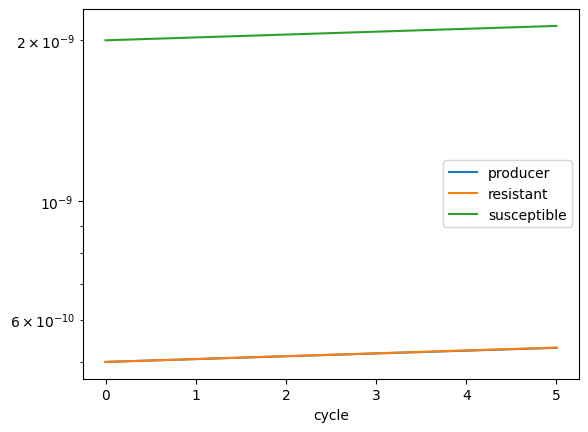

In [23]:
sim.total_biomass.plot(x = "cycle", logy = True)